# Iris Species

The Iris dataset was used in R.A. Fisher's classic 1936 paper, The Use of Multiple Measurements in Taxonomic Problems, and can also be found on the UCI Machine Learning Repository.

It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:

* Id
* SepalLengthCm
* SepalWidthCm
* PetalLengthCm
* PetalWidthCm
* Species

Source: https://archive.ics.uci.edu/dataset/53/iris

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("dataset/Iris.csv")

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
df.rename(columns=dict(zip(df.columns, [col.lower() for col in df])), inplace=True)

In [6]:
df.groupby("species").agg({"id": "nunique"}).rename(columns={"id":"# of Unique Species"})

,# of Unique Species
species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


In [7]:
df.columns

Index(['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm',
       'species'],
      dtype='object')

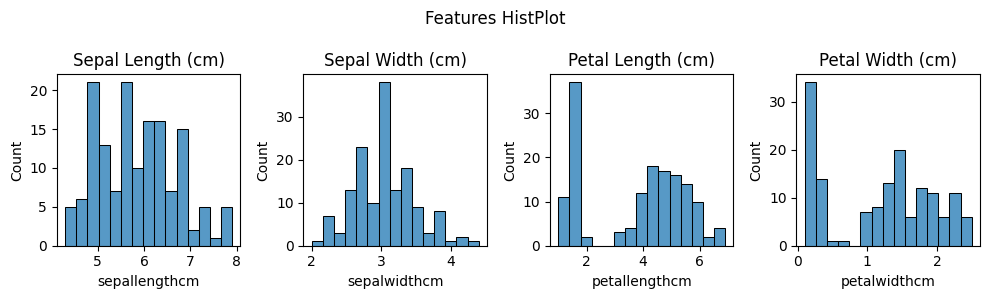

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10, 3))

fig.suptitle("Features HistPlot")

sns.histplot(data=df, x="sepallengthcm", ax=ax[0], bins=15)
ax[0].set_title("Sepal Length (cm)")

sns.histplot(data=df, x="sepalwidthcm", ax=ax[1], bins=15)
ax[1].set_title("Sepal Width (cm)")

sns.histplot(data=df, x="petallengthcm", ax=ax[2], bins=15)
ax[2].set_title("Petal Length (cm)")

sns.histplot(data=df, x="petalwidthcm", ax=ax[3], bins=15)
ax[3].set_title("Petal Width (cm)")

fig.tight_layout()
plt.show()

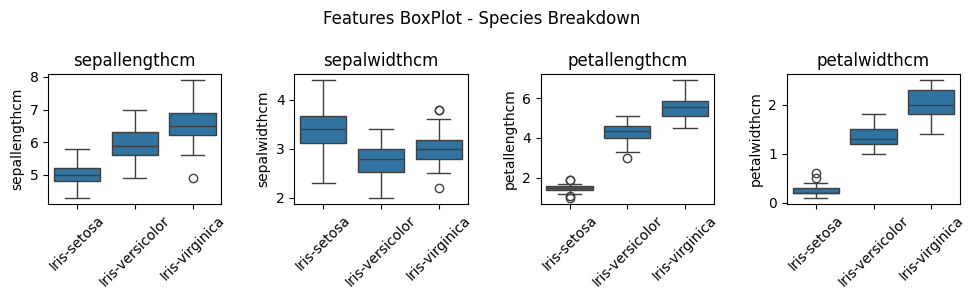

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10, 3))

fig.suptitle("Features BoxPlot - Species Breakdown")

for i, ax in enumerate(ax.flatten()):
    sns.boxplot(data=df, x="species", y=df.columns[1:5][i], ax=ax)
    ax.set_title(f"{df.columns[1:5][i]}")
    ax.set_xlabel('') 
    ax.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

In [10]:
df.drop("id", axis=1, inplace=True)

## Scaling Features - Only for visualisation

In [11]:
scaler = StandardScaler()

In [12]:
df_scaled = scaler.fit_transform(df.iloc[:, :-1])

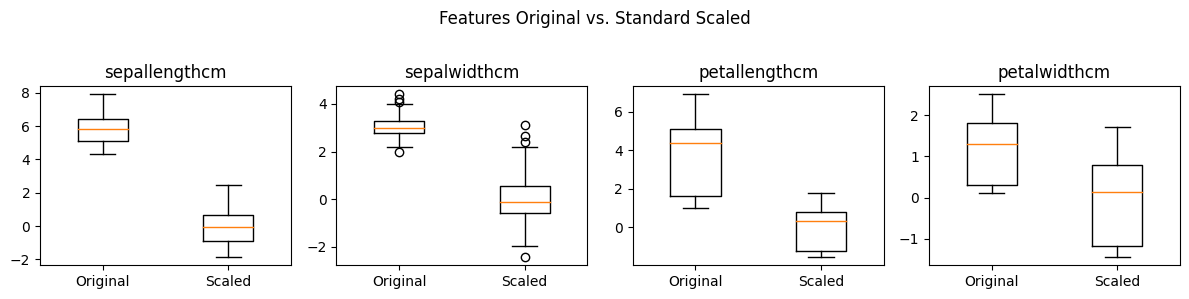

In [13]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 3))

fig.suptitle("Features Original vs. Standard Scaled")

for i, ax in enumerate(axes.flatten()):
    ax.boxplot(df.iloc[:, i], positions=[0], widths=0.4)
    ax.boxplot(df_scaled[:, i], positions=[1], widths=0.4)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Original', 'Scaled'])
    ax.set_title(df.columns[i])

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Single-layer perceptron

### Creating Model - One Layer, Softmax Activation
### Steps

1. Creating a Model - Layer Weights and Biases
2. Define Forward propagation
3. Define Loss Function (mean)
4. Define Accuracy (mean)
5. Define Training (layers, biases, optimizer, train step)

In [154]:
def create_model(input_shape, output_shape, seed=42):
    """ Creating a One Layer Model
    Args: 
        input_shape: Input shape, => number of features
        output_shape: Output nodes / # of target class
        seed: Seed number for random.normal (reproducibility reason)
    Returns:
        layer_1 and bias_1 tf Variables
    """

    initializer = tf.initializers.RandomNormal(seed=seed)

    layer_1 = tf.Variable(initializer(shape=(input_shape, output_shape)), dtype=tf.float32, name="Weights_L1")
    bias_1 = tf.Variable(tf.zeros((output_shape,)), name="Biases_L1", dtype=tf.float32)

    return layer_1, bias_1

In [155]:
@tf.function
def forward_pass(input, weight, bias):
    """ Forward pass
    Args:
        input: Input features
        weight: Weights
        bias: Biases
    Returns:
        Softmax of (matmul+bias) layer output
    """
    return tf.nn.softmax(tf.matmul(input, weight) + bias)

In [156]:
@tf.function
def loss_fn(y_pred, y_true):
    """ Calculate Loss
    Args:
        y_pred: predictions
        y_true: true labels
    Returns:
        Mean loss    
    """

    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

In [157]:
@tf.function
def accuracy_fn(y_pred, y_true):
    """ Return Accuracy
    Args:
        y_red: Prediction
        y_true: True label
    Return: 
        Mean Accuracy
    """
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

In [158]:
l1, b1 = create_model(4, 3)
initializer = tf.initializers.RandomNormal(seed=42)
sample_input = tf.Variable(initializer(shape=(1, 4)), dtype=tf.float32)
pred = forward_pass(sample_input, l1, b1)
true = tf.Variable(np.array([[0, 1, 0]]))

In [ ]:
loss_fn(pred, true)

In [ ]:
accuracy_fn(pred, true)

In [161]:
def train_model(X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs):
    layer_1, layer_1_bias = create_model(X_train.shape[1], y_train.shape[1])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = forward_pass(inputs, layer_1, layer_1_bias)
            loss = loss_fn(targets, predictions)

        gradients = tape.gradient(loss, [layer_1, layer_1_bias])
        optimizer.apply_gradients(zip(gradients, [layer_1, layer_1_bias]))
        return loss

    best_test_accuracy = 0
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):
            x_batch = X_train[step:step+batch_size]
            y_batch = y_train[step:step+batch_size]
            loss = train_step(x_batch, y_batch)
        
        val_predictions = forward_pass(X_test, layer_1, layer_1_bias)
        val_accuracy = accuracy_fn(y_test, val_predictions)
        if val_accuracy > best_test_accuracy:
            best_test_accuracy = val_accuracy
    
    return best_test_accuracy

In [162]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [163]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs_list = [5, 50, 100, 200]

params = []
accuracy_list = []

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in epochs_list: ## Test Combinations on 5 fold
            accuracy_current_config = []

            for i, (train_index, test_index) in enumerate(skf.split(X, y)):

                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                y_train = pd.get_dummies(y_train).astype("float32")
                y_test = pd.get_dummies(y_test).astype("float32")

                scaler = StandardScaler()

                X_train = scaler.fit_transform(X_train).astype("float32")
                X_test = scaler.transform(X_test).astype("float32")

                val_accuracy = train_model(X_train, y_train, X_test, y_test, lr, bs, epochs)
                accuracy_current_config.append(val_accuracy)
            
            accuracy_list.append(accuracy_current_config)
            params.append([lr, bs, epochs])
            
            print(f"LR: {lr}, Batch Size: {bs}, Epochs: {epochs}, Val Accuracy: {np.mean(accuracy_current_config):.4f}")


In [ ]:
print(f"Best 5 fold mean accuracy: {round(np.max(np.mean(np.array(accuracy_list), axis=1)), 4)}")

In [166]:
best_params = params[np.argmax(np.mean(np.array(accuracy_list), axis=1))]

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

y_train = pd.get_dummies(y_train).astype("float32")
y_test = pd.get_dummies(y_test).astype("float32")

In [203]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype("float32")
X_test = scaler.transform(X_test).astype("float32")

In [204]:
final_layer_1, final_layer_1_bias = create_model(X_train.shape[1], y_train.shape[1])
final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params[0])

In [205]:
@tf.function
def final_train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, final_layer_1, final_layer_1_bias)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, [final_layer_1, final_layer_1_bias])
    final_optimizer.apply_gradients(zip(gradients, [final_layer_1, final_layer_1_bias]))
    return loss

In [ ]:
for epoch in range(best_params[2]):
    for step in range(0, len(X_train), best_params[1]):
        x_batch = X_train[step:step+best_params[1]]
        y_batch = y_train[step:step+best_params[1]]
        loss = final_train_step(x_batch, y_batch)

test_predictions = forward_pass(X_test, final_layer_1, final_layer_1_bias)
test_accuracy = accuracy_fn(y_test, test_predictions)
print(f"Final test accuracy: {test_accuracy:.4f}")

In [ ]:
final_layer_1

In [ ]:
final_layer_1_bias

In [ ]:
plt.figure(figsize=(8, 5))
plt.imshow(final_layer_1, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight value')
plt.title('Weights of the Layer-1')
plt.xlabel('Node index')
plt.ylabel('Input feature index')
plt.xticks(ticks=np.arange(final_layer_1.shape[1]), labels=[f'Node {i+1}' for i in range(final_layer_1.shape[1])])
plt.yticks(ticks=np.arange(final_layer_1.shape[0]), labels=[f'Feature {i+1}' for i in range(final_layer_1.shape[0])])
plt.show()

In [210]:
y_pred = tf.argmax(test_predictions, axis=1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [ ]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 3

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

# Summary 

The accuracy looks nice on 5 Fold, ~ 98%, time to test MLP!

# Multilayer perceptron

### Creating Model - Two-Three Layer, Relu then Softmax Activation
### Steps

1. Creating a Model - Layer Weights and Biases
2. Define Forward propagation
3. Define Loss Function (mean)
4. Define Accuracy (mean)
5. Define Training (layers, biases, optimizer, train step)

In [14]:
def create_model(input_shape, output_shape, hidden_layer_nodes=tuple, seed=42):
    """ Define Model architecture
    Args:
        input_shape: input layer shape (number of nodes)
        output_shape: output layer shape (number of nodes) 
        hidden_layer_nodes: hidden layer shapes (number of hidden nodes in a list)
    Return:
        layers, biases    
    """

    layers = []
    biases = []

    initializer = tf.initializers.RandomNormal(seed=seed)

    l_input_w = tf.Variable(initializer(shape=(input_shape, hidden_layer_nodes[0])), dtype=tf.float32, name="Weights_input")
    l_input_b = tf.Variable(tf.zeros(shape=(hidden_layer_nodes[0], )), dtype=tf.float32, name="Biases_input")

    layers.append(l_input_w)
    biases.append(l_input_b)

    for i in range(len(hidden_layer_nodes)):
        if i != len(hidden_layer_nodes)-1:
            l_w = tf.Variable(initializer(shape=(hidden_layer_nodes[i], hidden_layer_nodes[i+1])), dtype=tf.float32, name=f"Weights_l{i+1}")
            l_b = tf.Variable(tf.zeros(shape=(hidden_layer_nodes[i+1],)), dtype=tf.float32, name=f"Biases_l{i+1}")     

            layers.append(l_w)
            biases.append(l_b)

        else:
            l_w = tf.Variable(initializer(shape=(hidden_layer_nodes[i], output_shape)), dtype=tf.float32, name="Weights_output")
            l_b = tf.Variable(tf.zeros(shape=(output_shape,)), dtype=tf.float32, name="Biases_output")
        
            layers.append(l_w)
            biases.append(l_b)
    

    return layers, biases


In [15]:
layers, biases = create_model(4, 3, (4, 4))

In [16]:
layers

[<tf.Variable 'Weights_input:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.00079085, -0.07950435,  0.00517972,  0.0405873 ],
        [-0.08051775, -0.07895523,  0.03320629,  0.01739371],
        [ 0.0328981 ,  0.09575269,  0.01707336,  0.00210763],
        [ 0.06077656,  0.00131572, -0.03984767,  0.00479649]],
       dtype=float32)>,
 <tf.Variable 'Weights_l1:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.00079085, -0.07950435,  0.00517972,  0.0405873 ],
        [-0.08051775, -0.07895523,  0.03320629,  0.01739371],
        [ 0.0328981 ,  0.09575269,  0.01707336,  0.00210763],
        [ 0.06077656,  0.00131572, -0.03984767,  0.00479649]],
       dtype=float32)>,
 <tf.Variable 'Weights_output:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.00079085, -0.07950435,  0.00517972],
        [ 0.0405873 , -0.08051775, -0.07895523],
        [ 0.03320629,  0.01739371,  0.0328981 ],
        [ 0.09575269,  0.01707336,  0.00210763]], dtype=float32)>]

In [17]:
biases

[<tf.Variable 'Biases_input:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'Biases_l1:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'Biases_output:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [18]:
@tf.function
def forward_pass(input, layers, biases):

    for i in range(len(layers)):
        if i == 0:
            x = tf.nn.relu(tf.matmul(input, layers[i]) + biases[i])
        elif i == len(layers)-1:
            x = tf.matmul(x, layers[i]) + biases[i]
        else:
            x = tf.nn.relu(tf.matmul(x, layers[i]) + biases[i])

    return tf.nn.softmax(x)

In [19]:
@tf.function
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))

In [27]:
def train_model(X_train, y_train, X_test, y_test, hidden_layer_nodes, learning_rate, batch_size, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    layers, biases = create_model(X_train.shape[1], y_train.shape[1], hidden_layer_nodes=hidden_layer_nodes)

    @tf.function
    def train_step(inputs, targets, layers, biases, optimizer):
        with tf.GradientTape() as tape:
            predictions = forward_pass(inputs, layers, biases)
            loss = loss_fn(targets, predictions)
        
        gradients = tape.gradient(loss, layers+biases)
        optimizer.apply_gradients(zip(gradients, layers+biases))
        
        return loss
    
    best_test_accuracy = 0
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):
            x_batch = X_train[step:step + batch_size]
            y_batch = y_train[step:step + batch_size]
            loss = train_step(x_batch, y_batch, layers, biases, optimizer)
        
        test_predictions = forward_pass(X_test, layers, biases)
        test_accuracy = accuracy_fn(y_test, test_predictions)
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
    
    return best_test_accuracy

In [28]:
def accuracy_fn(y_true, y_pred):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
skf = StratifiedKFold(n_splits=5)

In [30]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs_list = [5, 50, 100, 200]
hidden_layer_sizes = [(4, ), (4, 4), (4, 4, 4)]

params = []
accuracy_list = []

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in epochs_list:
            for hidden_sizes in hidden_layer_sizes:
                accuracy_current_config = []

                for i, (train_index, test_index) in enumerate(skf.split(X, y)):
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    y_train = pd.get_dummies(y_train).astype("float32")
                    y_test = pd.get_dummies(y_test).astype("float32")

                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train).astype("float32")
                    X_test = scaler.transform(X_test).astype("float32")

                    val_accuracy = train_model(X_train, y_train, X_test, y_test, hidden_sizes, lr, bs, epochs)
                    print(val_accuracy)
                    accuracy_current_config.append(val_accuracy)

                accuracy_list.append(accuracy_current_config)
                params.append([lr, bs, epochs, hidden_sizes])
                
                print(f"LR: {lr}, Batch Size: {bs}, Epochs: {epochs}, Hidden Layers: {hidden_sizes}, Val Accuracy: {np.mean(accuracy_current_config):.4f}")


tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
LR: 0.0001, Batch Size: 16, Epochs: 5, Hidden Layers: (4, 4), Val Accuracy: 0.3333
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
tf.Tensor(0.33333334, shape=(), dtype=float32)
LR: 0.0001, Batch Size: 16, Epochs: 5, Hidden Layers: (4, 4, 4), Val Accuracy: 0.3333
tf.Tensor(0.6666667, shape=(), dtype=float32)
tf.Tensor(0.6666667, shape=(), dtype=float32)
tf.Tensor(0.6666667, shape=(), dtype=float32)
tf.Tensor(0.6666667, shape=(), dtype=float32)
tf.Tensor(0.6333333, shape=(), dtype=float32)
LR: 0.0001, Batch Size: 16, Epochs: 50, Hidden Layers: (4, 4), Val Accuracy: 0.6600
tf.Tensor(0.56666666, shape=(), dtype=float32)


In [31]:
print(f"Best 5 fold mean accuracy: {round(np.max(np.mean(np.array(accuracy_list), axis=1)), 4)}")

Best 5 fold mean accuracy: 0.9866999983787537


In [32]:
best_params = params[np.argmax(np.mean(np.array(accuracy_list), axis=1))]

In [62]:
best_params

[0.01, 16, 200, (4, 4)]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

y_train = pd.get_dummies(y_train).astype("float32")
y_test = pd.get_dummies(y_test).astype("float32")

In [64]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype("float32")
X_test = scaler.transform(X_test).astype("float32")

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params[0])
layers, biases = create_model(X_train.shape[1], y_train.shape[1], hidden_layer_nodes=best_params[3])

In [66]:
@tf.function
def final_train_step(inputs, targets, layers, biases):

    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, layers, biases)
        loss = loss_fn(targets, predictions)
    
    gradients = tape.gradient(loss, layers+biases)
    optimizer.apply_gradients(zip(gradients, layers+biases))
    
    return loss

In [67]:
for epoch in range(best_params[2]):
    for step in range(0, len(X_train), best_params[1]):
        x_batch = X_train[step:step+best_params[1]]
        y_batch = y_train[step:step+best_params[1]]
        loss = final_train_step(x_batch, y_batch, layers, biases)

test_predictions = forward_pass(X_test, layers, biases)
test_accuracy = accuracy_fn(y_test, test_predictions)
print(f"Final test accuracy: {test_accuracy:.4f}")

Final test accuracy: 1.0000


In [70]:
layers

[<tf.Variable 'Weights_input:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.43462378,  0.26587576, -1.0002661 ,  0.16486914],
        [-0.96162546, -0.25556707,  0.8504019 , -0.21013585],
        [ 1.3335925 , -0.38091767, -1.1666492 ,  1.4936198 ],
        [ 1.2262242 , -0.37841985, -1.2751911 ,  1.2532227 ]],
       dtype=float32)>,
 <tf.Variable 'Weights_l1:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 7.6230896e-01, -1.8938977e+00, -5.4053940e-02, -1.9388732e-02],
        [-1.1521289e+00, -2.8837627e-01, -2.6279209e-02, -4.2556252e-02],
        [ 6.1139268e-01,  1.3373269e+00,  5.6624576e-03, -2.4750028e-04],
        [ 1.6383249e+00, -4.1476226e-01, -5.9135053e-03, -5.5030573e-02]],
       dtype=float32)>,
 <tf.Variable 'Weights_output:0' shape=(4, 3) dtype=float32, numpy=
 array([[-1.2050759 , -1.5741005 ,  1.7757468 ],
        [ 1.1940591 , -1.3259282 , -1.136074  ],
        [-0.01165665,  0.06965369,  0.02631426],
        [ 0.03741932,  0.07545428,  0.06013547]], dtype=floa

In [71]:
biases

[<tf.Variable 'Biases_input:0' shape=(4,) dtype=float32, numpy=array([-0.05044563,  1.1232016 ,  0.42926735, -0.81782967], dtype=float32)>,
 <tf.Variable 'Biases_l1:0' shape=(4,) dtype=float32, numpy=array([-0.5832495 ,  0.5768865 , -0.09905625, -0.06388999], dtype=float32)>,
 <tf.Variable 'Biases_output:0' shape=(3,) dtype=float32, numpy=array([-2.1542435,  3.6211164, -1.8735726], dtype=float32)>]

In [74]:
y_pred = tf.argmax(test_predictions, axis=1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

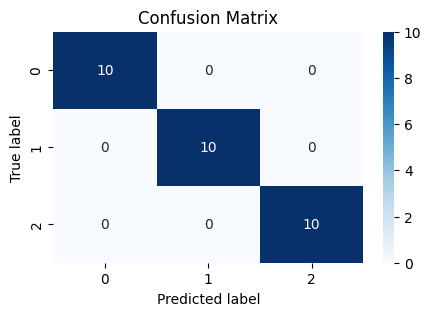

Validation Accuracy: 1.0000


In [75]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [79]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 3

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
Class 1:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
Class 2:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Macro-average F1-score: 1.0000


# Summary 

The accuracy looks nice on 5 Fold, ~ 98%, time to test MLP!

In [122]:
y_train.iloc[0, :]

Iris-setosa        1.0
Iris-versicolor    0.0
Iris-virginica     0.0
Name: 8, dtype: float32

In [116]:
forward_pass(tf.constant(X_train[[0]]), layers, biases).numpy().tolist()

[[0.9999924898147583, 6.924832632648759e-06, 6.13666145454772e-07]]